ND

In [40]:
import numpy as np
import copy
import os
import yaml
yaml.Dumper.ignore_aliases = lambda *args : True
import utils
import matplotlib.pyplot as plt
import tqdm
import glob


import importlib
importlib.reload(utils)

<module 'utils' from '/n/home12/cfpark00/ML/ToyCompDiff/utils.py'>

In [41]:
def get_ntr_ntest(ns,n_per=128,method="fid_axis"):
    indsgrid=np.stack(np.meshgrid(*([np.arange(n) for n in ns]),indexing="ij"),axis=-1)
    if method=="fid_axis":
        n_nonzero=np.sum(indsgrid!=0,axis=-1)
        sel=(n_nonzero<=1).flatten().astype(int)
        ntr=(sel*n_per).tolist()
        ntest=((1-sel)*n_per).tolist()
    else:
        raise ValueError("Unknown method")
    return ntr,ntest

In [50]:
config={
    'experiment_directory': None,
    'seed': None,
    "dataset":"images_1",
    'n_samples_train':[],
    'n_samples_test':[],
    'n_samples_train_gen':[],
    'n_samples_test_gen':[],
    "data_params":{
        "n_classes":64,
        "image_size": 32,
        "noise_level": 0.001,
        "comp_dims":{"shape":2,"x":2,"y":2,"color":2,"size":2,"bg_color":2},
        
        "shape":{"names":["circle","triangle"]},
        "x":{"min":-0.4,"max":0.4,"n":2,"s":0.05,"s_n":0.0},
        "y":{"min":-0.4,"max":0.4,"n":2,"s":0.05,"s_n":0.0},
        "color":{"means":[[0.8, 0.2, 0.2], [0.2, 0.2, 0.8]],"mins":[[0.725, 0.125, 0.125], [0.125, 0.125, 0.725]],
                 "maxs":[[0.875, 0.275, 0.275], [0.275, 0.275, 0.875]],"s_n":0.0},
        "size":{"means":[0.625, 0.275],"mins":[0.49375, 0.14375],"maxs":[0.75625, 0.40625],"s_n":0.00,"min":0.1},
        "bg_color":{"means":[[0.65, 0.65, 0.65], [0.35, 0.35, 0.35]],"mins":[[0.6125, 0.6125, 0.6125], [0.3125, 0.3125, 0.3125]],
                    "maxs":[[0.6875, 0.6875, 0.6875],[0.3875, 0.3875, 0.3875]],"s_n":0.0},
    },
    "model_params":{
        "model_type": "VDiff",
        "optimizer_type": "AdamW",
        "optimizer_params": {"lr": 0.001,"weight_decay": 0.01},
        "data_noise":1e-3,
        "beta_settings": {"type":"logsnr","noise_schedule":"learned_linear","gamma_min":-5., "gamma_max":10.},
        "network_params": {"mid_attn":True,
                           "v_conditioning_type":"sep_mlp",
                           "v_conditioning_dims":[11],
                           "chs": [64,128,128],
                           "num_res_blocks":2,
                           "init_scale":0.5},
    },
    "batch_size": 64,
    "train_ratio": 0.85,
    'num_steps': 1_000_000,
    'save_steps_start': 50,
    'save_steps': 200,

    "fig_n_col": 8,
}

In [51]:
ntr,ntest=get_ntr_ntest([2,2,2,2,2,2],n_per=4096,method="fid_axis")
ntr_gen,ntest_gen=get_ntr_ntest([2,2,2,2,2,2],n_per=32,method="fid_axis")
np.sum(ntr),np.sum(ntest),np.sum(ntr_gen),np.sum(ntest_gen)

(28672, 233472, 224, 1824)

In [56]:
configs=[]
for seed in [0,100,200,300,400]:
    fol=f"images_1/2x2x2x2x2x2/"
    experiment_name=f"seed={seed}"
    config_=copy.deepcopy(config)
    config_['n_samples_train']=ntr
    config_['n_samples_test']=ntest_gen #intentional
    config_['n_samples_train_gen']=ntr_gen
    config_['n_samples_test_gen']=ntest_gen
    config_=utils.process_config(config_,check_only=True)

    experiment_directory=os.path.join("data",fol,experiment_name)
    config_["experiment_directory"]=experiment_directory
    yaml_fol=os.path.join("yamls",fol)
    os.makedirs(yaml_fol,exist_ok=True)
    yaml_path=os.path.join(yaml_fol,experiment_name+".yaml")
    yaml.dump(config_,open(yaml_path,"w"))
    configs.append(config_)

In [53]:
config_=configs[0]
n_classes=config_['data_params']['n_classes']
config_['n_samples_train']=[0 for _ in range(n_classes)]
config_['n_samples_test']=[0 for _ in range(n_classes)]
config_['n_samples_train_gen']=[32 for _ in range(n_classes)]
config_['n_samples_test_gen']=[32 for _ in range(n_classes)]
x_tr,y_tr,l_tr,x_te,y_te,l_te=utils.generate_data(config_,forgen=True)

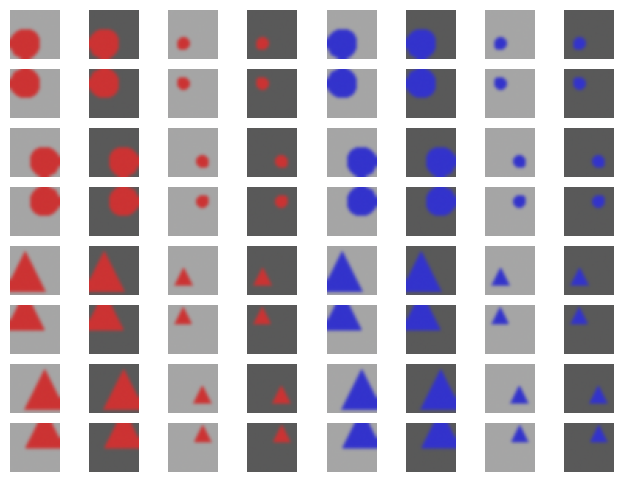

In [54]:
fig,axs=plt.subplots(8,8,figsize=(8,6))
for l in range(64):
    ax=axs.flatten()[l]
    ax.imshow(x_te[l_te==l][0].transpose(2,1,0),origin="lower")
    ax.axis("off")

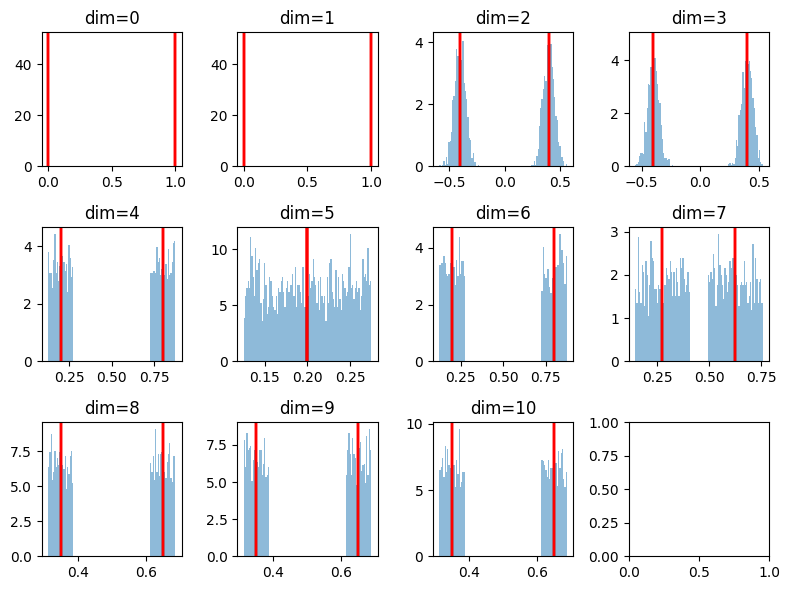

In [55]:
import matplotlib.pyplot as plt

l_te_unique=np.unique(l_te)

fig,axs=plt.subplots(3,4,figsize=(8,6))
for dim in range(y_te.shape[1]):
    ax=axs.flatten()[dim]
    y_tes=[y_te[l_te==l][0,dim] for l in l_te_unique]
    ax.hist(y_tr[:,dim],bins=100,density=True,alpha=0.5)
    for y in y_tes:
        ax.axvline(y,color="r",alpha=0.4)
    ax.set_title(f"dim={dim}")
    #ax.set_xlim(-0.1,1.1)
plt.tight_layout()